# Implementation

Based on: C-Jui Hsieh, et al, A dual coordinate descent method for large-scale linear svm, Proceedings of
the 25th international conference on Machine learning, pp. 408-415, 2008  
https://icml.cc/Conferences/2008/papers/166.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class SVM_DCD():
    def __init__(self, c):
        # initialize the model with a C hyperparameter
        self.alpha = None
        self.x = None
        self.fitted = False
        self.c = c
    
    def iteration(self, i, y, z):
        # subiteration to be performed during learning; based on the algorithm 1 from the article
        # this is L1-SVM, therefore we assume U=C and D=0
        alpha0 = self.alpha[i]
        G = z * (self.x @ y) - 1
        if self.alpha[i] == 0:
            PG = min(G, 0)
        elif self.alpha[i] == self.c:
            PG = max(G, 0)
        else:
            PG = G
        if PG != 0:
            q = y @ y
            if q != 0:
                self.alpha[i] = min(max(self.alpha[i] - G/q, 0), self.c)
            else: # shortcut for Q_ii=0
                self.alpha[i] = self.c
            self.x = self.x + (self.alpha[i] - alpha0) * z * y
    
    def fit(self, Y: np.array, Z: np.array):
        nrow, ncol = Y.shape
        self.alpha = np.zeros(nrow) # the alpha vector contains as many elements as observations
        self.x = np.zeros(ncol) # coefficients
        # for any other alpha, we would assign:
        # self.x = np.sum(Z * self.alpha * Y.T, axis=1)
        for i in range(nrow):
            self.iteration(i, Y[i], Z[i])
        self.fitted = True
        return self
    
    def predict(self, Y: np.array):
        preds = self.x @ Y.T
        return np.sign(preds)

# Sample data

## Train data

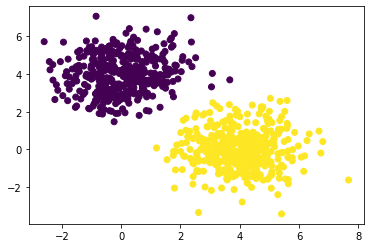

In [3]:
x1 = np.append(np.random.normal(0, 1, 400), np.random.normal(4, 1, 400))
x2 = np.append(np.random.normal(4, 1, 400), np.random.normal(0, 1, 400))
y = np.append(np.full(400, -1), np.full(400, 1))
x = np.column_stack((x1, x2))
plt.scatter(x[:, 0], x[:, 1], c=y)

## Test data (without classes)

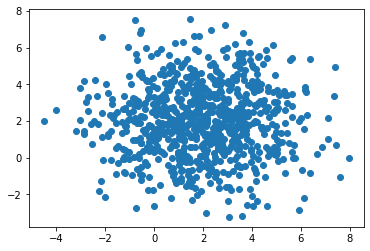

In [4]:
x1_test = np.random.normal(2, 2, 800)
x2_test = np.random.normal(2, 2, 800)
x_test = np.column_stack((x1_test, x2_test))
plt.scatter(x_test[:, 0], x_test[:, 1])

## Learning

In [5]:
model = SVM_DCD(1)

In [6]:
model.fit(x, y)

In [9]:
p = model.predict(x_test)

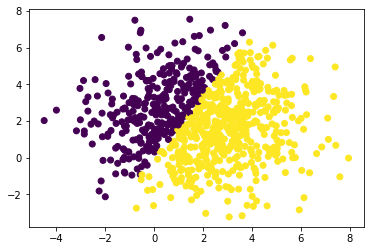

In [10]:
plt.scatter(x_test[:, 0], x_test[:, 1], c=p)